<a href="https://colab.research.google.com/github/trentfridey/qosf-screening/blob/master/task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow==2.1.0
!pip install tensorflow-quantum

     |████████████████████████████████| 421.8MB 43kB/s 
     |████████████████████████████████| 3.9MB 50.6MB/s 
     |████████████████████████████████| 450kB 46.3MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=aea3578416301371e7fc2046d98a39fe2c522fa43c0cd9987c79a7a2bb4a9b9a
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully 

In [3]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

# Task 1

Initialize the state of 4 qubits $|\psi_0\rangle = |0000\rangle$.

The circuit will consist of a number of layers $L$, each composed of a even and odd block.

The odd block implements the unitary:

$$
U_{2k+1} (\theta_{2k+1}) = R_x(\theta_{2k+1,1})\otimes R_x(\theta_{2k+1,2}) \otimes R_x(\theta_{2k+1,3}) \otimes R_x(\theta_{2k+1,4})
$$

Whereas the even block implements

$$
U_{2k} (\theta_{2k}) = CZ(3,4)CZ(2,4)CZ(2,3)CZ(1,4)CZ(1,3)CZ(1,2)[R_z(\theta_{2k,1})\otimes R_z(\theta_{2k,2}) \otimes R_z(\theta_{2k,3}) \otimes R_z(\theta_{2k,4})]
$$

Let's implement the blocks using Cirq:

In [4]:
# initialize our qubits:

qubits = [cirq.GridQubit(x,y) for x in range(2) for y in range(2)]

# initialize our params (theta)

thetas = sympy.symbols('t1:9')

In [5]:
thetas[0:4]

(t1, t2, t3, t4)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


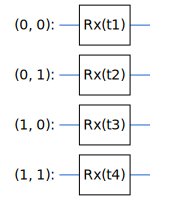

In [6]:
# Lets construct the odd block first
# We will need the Rx gate as well as 4 parameters

odd = cirq.Circuit()
for (qubit, theta) in zip(qubits, thetas[0:4]):
  odd.append(cirq.rx(theta).on(qubit))

SVGCircuit(odd)

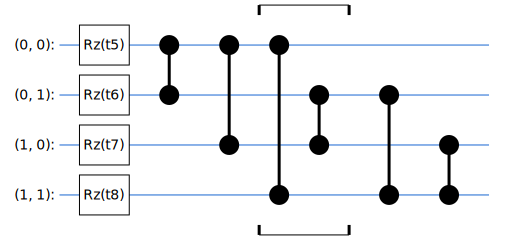

In [7]:
# Now we construct the even block

even = cirq.Circuit()

for (qubit, theta) in zip(qubits, thetas[4:8]):
  even.append(cirq.rz(theta).on(qubit))

for i in range(len(qubits)-1):
  for j in range(i+1, len(qubits)):
    even.append(cirq.CZ(qubits[i], qubits[j]))


SVGCircuit(even)

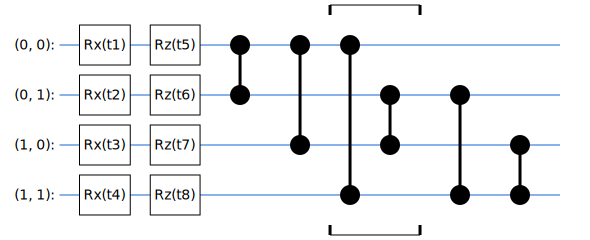

In [8]:
# Now we can combine them into one layer

one_layer = cirq.Circuit()
one_layer.append([odd, even])

SVGCircuit(one_layer)

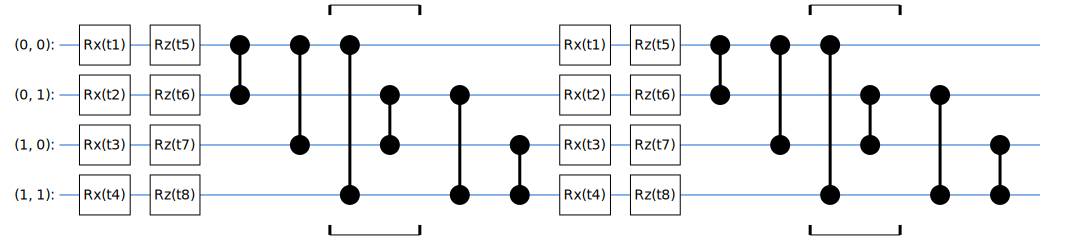

In [9]:
# but if we continue this way, we don't get new params at each layer:

two_layers = cirq.Circuit()
two_layers.append([one_layer, one_layer])

SVGCircuit(two_layers)

In [20]:
# We need to construct our circuit like it is done in https://www.tensorflow.org/quantum/tutorials/qcnn#152_qcnn_layers

def odd_block(qubits, angles):
  odd = cirq.Circuit()
  for (qubit, angle) in zip(qubits, angles):
    odd.append(cirq.rx(angle).on(qubit))
  return odd

def even_block(qubits, angles):
  even = cirq.Circuit()
  for (qubit, angle) in zip(qubits, angles):
    even.append(cirq.rz(angle).on(qubit))
  for i in range(len(qubits)-1):
    for j in range(i+1, len(qubits)):
      even.append(cirq.CZ(qubits[i], qubits[j]))
  return even

def layer(qubits, angles):
  odd = odd_block(qubits, angles[0:4])
  even = even_block(qubits, angles[4:8])
  output_layer = cirq.Circuit()
  output_layer.append([odd, even])
  return output_layer

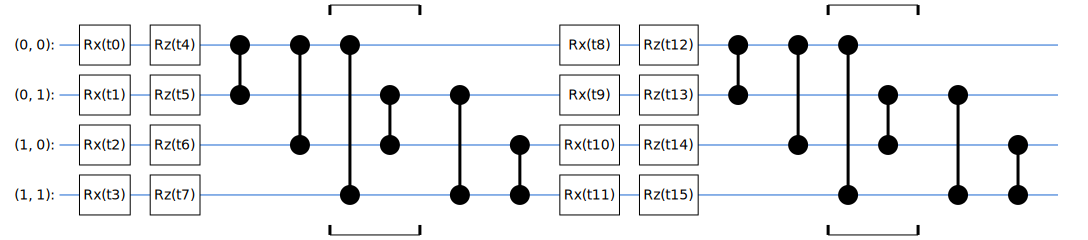

In [29]:
# The proper two-layer construction:
two_layers = cirq.Circuit()
two_layers += layer(qubits, sympy.symbols('t0:8'))
two_layers += layer(qubits, sympy.symbols('t8:16'))

SVGCircuit(two_layers)

In [36]:
# Arbitrary number of layers:

def gen_layers(qubits, num_layers):
  output = cirq.Circuit()
  for l in range(num_layers):
    angles = sympy.symbols("t{}:{}".format(8*l, 8*(l+1)))
    output.append(layer(qubits, angles))
  return output

The figure of interest at this stage is the final state, $|\psi(\vec{\theta})\rangle$, and the quantity:

$$
\delta = || |\psi(\vec{\theta})\rangle - |\phi\rangle ||
= \sum_{i,j,k,l}|c_{ijkl}|^2
$$

$$
c_{ijkl} = \langle ijkl|\psi(\vec{\theta})\rangle - \langle ijkl|\phi\rangle
$$

Where $|\phi\rangle$ is a randomly chosen state.

We choose $|\phi\rangle = \frac{1}{\sqrt{2}}(|0000\rangle + |1111\rangle)$ 